In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize
from numba import jit 

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv', sep = ',')
deaths = pd.read_csv(url + 'time_series_covid19_deaths_global.csv', sep = ',')
recovered = pd.read_csv(url + 'time_series_covid19_recovered_global.csv', sep = ',')
new_cols = list(confirmed.columns[:4]) + list(confirmed.columns[4:].map(lambda x: '{0:02d}.{1:02d}.{2:d}'.format(int(x.split(sep='/')[1]), int(x.split(sep='/')[0]), int(x.split(sep='/')[2]))))
confirmed.columns = new_cols
recovered.columns = new_cols
deaths.columns = new_cols

In [2]:
country='Russia'
nt=26
con_c=confirmed[confirmed['Country/Region']==country][new_cols[nt:]].sum(axis=0).T
rec_c=recovered[recovered['Country/Region']==country][new_cols[nt:]].sum(axis=0).T
deaths_c=deaths[deaths['Country/Region']==country][new_cols[nt:]].sum(axis=0).T
fact_DI=con_c-rec_c-deaths_c
pop=144000000

NameError: name 'confirmed' is not defined

### Регионы

In [3]:
init_d=pd.read_csv('data_reg/rf.csv')
init_d=init_d.set_index('date')
init_d.con=init_d.con.apply(lambda x: x.replace(' ',''))
init_d.rec=init_d.rec.apply(lambda x: x.replace(' ','') if type(x)==str else 0)
init_d=init_d.fillna(0).astype('int32')
con_c=init_d.con
mr_c=init_d.mr
rec_c=init_d.rec
fact_DI=init_d.con-init_d.mr-init_d.rec
pop_len=140*10**6
print(pop_len)

start=pd.to_datetime(init_d.index[0],dayfirst=True)

140000000


In [22]:
N = pop_len*0.0048
# nu=0.024
nu=0.9
beta=0.3
gamma=1./14
theta=0.6
k=0.33
mu=0.001
alpha=0.11
k0=0
omega=0
my_t=336
t = np.linspace(0, my_t, my_t)

In [6]:
@jit(nopython=True)
def deriv(t, variables):
        S, E, I, R, D= variables    
        N   = S + E + I + R + D
        dS = -beta * S * (I+theta*E)*np.exp(-alpha*(I+theta*E)**k0) / N#-omega*S np.exp(-alpha*(I+theta*E)**k0))
        dE = beta * S * (I+theta*E)*np.exp(-alpha*(I+theta*E)**k0)/ N - k*E#-omega*E *np.exp(-alpha*(I+theta*E)**k0))
        dI = k*E-gamma*I-mu*I#-omega*I
        dR = gamma * I#+omega*(S+E+I)
        dD = mu*I
        return [dS, dE, dI, dR,dD]

In [7]:
E0=0
I0=2
R0=0
D0=1
S0=N-E0-I0-R0-D0
y0=S0,E0,I0,R0,D0
sol = solve_ivp(deriv,[0,my_t],y0,t_eval=np.arange(start=0, stop=my_t, step=1),method='LSODA')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


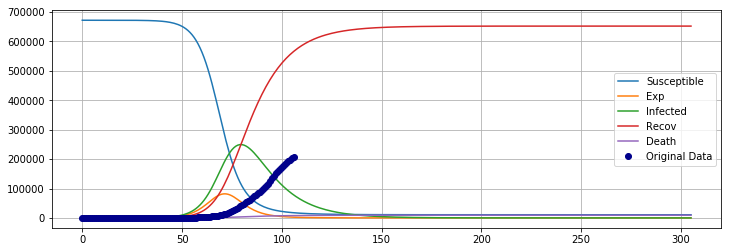

In [8]:
fig = plt.figure(figsize=(12,4))
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.plot(sol.t,sol.y[2])
plt.plot(sol.t,sol.y[3])
plt.plot(sol.t,sol.y[4])
plt.plot(np.arange(0,len(fact_DI.values)),fact_DI.values,"o",color='darkblue')
plt.grid("True")
plt.legend(["Susceptible","Exp","Infected","Recov","Death","Original Data"])

In [9]:
def sumsq(p):
    beta,gamma,theta,k,mu,alpha,k0=p
    def deriv(t, variables):  
        S, E, I, R, D= variables    
        N   = S + E + I + R + D
        dS = -beta * S * (I+theta*E)*np.exp(-alpha*(I+theta*E)**k0) / N#-omega*S np.exp(-alpha*(I+theta*E)**k0))
        dE = beta * S * (I+theta*E)*np.exp(-alpha*(I+theta*E)**k0)/ N - k*E#-omega*E *np.exp(-alpha*(I+theta*E)**k0))
        dI = k*E-gamma*I-mu*I#-omega*I
        dR = gamma * I#+omega*(S+E+I)
        dD = mu*I
        return [dS, dE, dI, dR,dD]
    sol = solve_ivp(deriv,[0,214],y0,t_eval=np.arange(start=0, stop=214, step=1),method='LSODA')
    return(np.sqrt(0.1*sum((sol.y[2][:len(fact_DI.values)]-fact_DI.values)**2)+\
               0.1*sum((sol.y[2][:len(fact_DI.values)]+sol.y[3][:len(fact_DI.values)]+sol.y[4][:len(fact_DI.values)]\
                    -con_c)**2)+\
                  0.1*sum((sol.y[3][:len(fact_DI.values)]-rec_c)**2)+\
                  0.7*sum((sol.y[4][:len(fact_DI.values)]-mr_c)**2))
          )

In [16]:
%%time
msol = minimize(sumsq,[beta, gamma,theta,k,mu,alpha,k0],method='Nelder-Mead')
print(msol.x)

[1.46683182e-01 1.59452619e-02 1.48386891e+00 2.43902333e-02
 8.13201428e-04 2.23437559e-01 2.73067000e-02]
CPU times: user 9.08 s, sys: 115 ms, total: 9.19 s
Wall time: 9.25 s


In [135]:
bounds_seird = [(0, 1),(0, 1),(0, 1),(0.1, 1),(0, 0.1),(0, 1),(0, 1)]

result_seird = optimize.differential_evolution(
    sumsq, 
    bounds=bounds_seird, 
    popsize=300,
    strategy='best1bin',
    tol=1e-2,
    recombination=0.7,
    mutation=0.7,
    maxiter=100,
    disp=False,
    seed=seed,
#     workers=-1
)
result_seird.x

In [3]:
print(1/msol.x[1],'дней, инфекционный период')
print(1/msol.x[3],'дней, инкубационный период')

In [23]:
beta, gamma,theta,k,mu,alpha,k0= msol.x

In [24]:
@jit(nopython=True)
def deriv(t, variables):
    S, E, I, R, D= variables    
    N   = S + E + I + R + D
    dS = -beta * S * (I+theta*E)*np.exp(-alpha*(I+theta*E)**k0) / N#-omega*S np.exp(-alpha*(I+theta*E)**k0))
    dE = beta * S * (I+theta*E)*np.exp(-alpha*(I+theta*E)**k0)/ N - k*E#-omega*E *np.exp(-alpha*(I+theta*E)**k0))
    dI = k*E-gamma*I-mu*I#-omega*I
    dR = gamma * I#+omega*(S+E+I)
    dD = mu*I
    return [dS, dE, dI, dR,dD]
sol = solve_ivp(deriv,[0,my_t],y0,t_eval=np.arange(start=0, stop=my_t, step=1),method='LSODA')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


значение пика 284227.0
пик в точке 2020-06-15 00:00:00


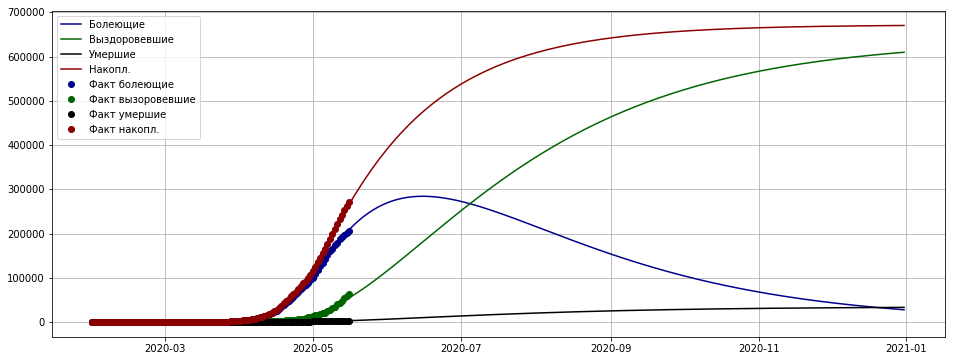

In [25]:
fig = plt.figure(figsize=(16,6))
# plt.plot(sol.t,sol.y[0])
# plt.plot(sol.t,sol.y[1])
my_date=pd.date_range(start=pd.to_datetime(start,dayfirst=True),periods=len(sol.t),freq='D')
plt.plot(my_date,sol.y[2],color='darkblue',label='Болеющие')
plt.plot(my_date,sol.y[3],color='darkgreen',label='Выздоровевшие')
plt.plot(my_date,sol.y[4],color='black',label='Умершие')
plt.plot(my_date,sol.y[2]+sol.y[3]+sol.y[4],color='darkred',label='Накопл.')
plt.plot(my_date[:len(fact_DI.values)],fact_DI.values,"o",color='darkblue',label='Факт болеющие')
plt.plot(my_date[:len(fact_DI.values)],init_d.rec.values,"o",color='darkgreen',label='Факт вызоровевшие')
plt.plot(my_date[:len(fact_DI.values)],init_d.mr.values,"o",color='black',label='Факт умершие')
plt.plot(my_date[:len(fact_DI.values)],con_c,"o",color='darkred',label='Факт накопл.')

plt.grid("True")
plt.legend()

print('значение пика', round(np.max(sol.y[2]),0))
print('пик в точке', my_date[np.argmax(sol.y[2])])

In [26]:
from datetime import datetime
dateTime = lambda self: self.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
myd=pd.DataFrame([sol.y[4],sol.y[3],sol.y[2]]).T#.to_excel('test123.xlsx')
myd.index=my_date
myd.columns=['mr','rec','con']
myd.loc['2020-02-29':].to_excel(dateTime(datetime)+'.xlsx')